# Tutorial : Classifying Orbit5k with giotto-deep

The Orbit5k dataset consists of a set of 5000 subsets $(S^{\rho_k})_{k = 1...1000}$ of 1000 points of $[0,1]^2$. For a given $\rho \in \{2.5, 3.5, 4.0, 4.1,4.3\}$, each subset $S^\rho \subset [0,1]^2 $ is generated randomly according to the following procedure:

1. Start with a uniformly randomly sampled point $(x_0,y_0)\in [0,1]^2$
2. For $n \geq 1$, generate $(x_{n+1},y_{n+1})$ inductively by : 

$$ x_{n+1} = x_{n} + \rho y_n(1-y_n) ~~~\text{mod }1$$
$$ y_{n+1} = y_{n} + \rho x_n(1-x_n) ~~~\text{mod }1$$

3. Define $S^\rho := \{(x_i,y_i) \mid i = 0...999 \}$

We generate $S^\rho$ 1000 times per values of $\rho$. 

The classification problem is then to recover the parameter $\rho$ from the persistence diagrams of $S^\rho$.






## Initialisation of the notebook

In [2]:
from IPython import get_ipython  # type: ignore
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

/tmp/ipykernel_29427/442910520.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
/tmp/ipykernel_29427/442910520.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')


In [3]:

from dotmap import DotMap
import json
import os

import numpy as np

# Import the PyTorch modules
import torch  # type: ignore
from torch import nn  # type: ignore
from torch.optim import SGD, Adam, RMSprop, AdamW  # type: ignore

# Import Tensorflow writer
from torch.utils.tensorboard import SummaryWriter  # type: ignore

from transformers.optimization import get_cosine_with_hard_restarts_schedule_with_warmup, get_constant_schedule_with_warmup, get_cosine_schedule_with_warmup

# Import the giotto-deep modules
from gdeep.data import OrbitsGenerator, DataLoaderKwargs
from gdeep.topology_layers import Persformer
from gdeep.pipeline import Pipeline
from gdeep.search import Gridsearch
import json

from optuna.pruners import MedianPruner, NopPruner

Using GPU!
Using GPU!
No TPUs...


## Let's load the dataset

### Define the dataset's characteristics

In [20]:
config_data = DotMap({
    'batch_size_train': 32,
    'num_orbits_per_class': 1_000,
    'validation_percentage': 0.0,
    'test_percentage': 0.0,
    'num_jobs': 8,
    'dynamical_system': 'classical_convention',
    'homology_dimensions': (0, 1),
    'dtype': 'float32',
    'arbitrary_precision': False
})


# Define the data loader




og = OrbitsGenerator(num_orbits_per_class=config_data.num_orbits_per_class,
                     homology_dimensions = config_data.homology_dimensions,
                     validation_percentage=config_data.validation_percentage,
                     test_percentage=config_data.test_percentage,
                     n_jobs=config_data.num_jobs,
                     dynamical_system = config_data.dynamical_system,
                     dtype=config_data.dtype,
                     arbitrary_precision=config_data.arbitrary_precision,
                     )


point_clouds = og.get_orbits()
point_clouds.shape

(5000, 1000, 2)

### Visualize a few pointclouds

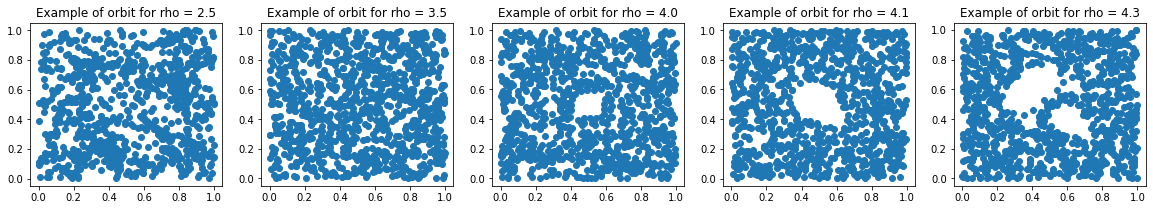

In [24]:
import matplotlib.pyplot as plt
rho_values = [2.5, 3.5, 4.0, 4.1,4.3]
fig, ax = plt.subplots(ncols=len(rho_values), figsize = (20,3))
for i in range(len(rho_values)):
    x , y = point_clouds[i*config_data.num_orbits_per_class,:,0], point_clouds[i*config_data.num_orbits_per_class,:,1] 
    ax[i].scatter(x, y)
    ax[i].set_title('Example of orbit for rho = ' + str(rho_values[i]))



In [3]:

#dataloader PDs dataset

dataloaders_dicts = DataLoaderKwargs(train_kwargs = {"batch_size":
                                                        config_data.batch_size_train,},
                                     val_kwargs = {"batch_size": 4},
                                     test_kwargs = {"batch_size": 3})


if config_data.arbitrary_precision:
    orbits = np.load(os.path.join('data', 'orbit5k_arbitrary_precision.npy'))
    og.orbits_from_array(orbits)

if len(config_data.homology_dimensions) == 0:
    dl_train, _, _ = og.get_dataloader_orbits(dataloaders_dicts)
else:
    dl_train, _, _ = og.get_dataloader_persistence_diagrams(dataloaders_dicts)


#Configs



config_model = DotMap({
    'implementation': 'Old_SetTransformer', # SetTransformer, PersFormer,
    # PytorchTransformer, DeepSet, X-Transformer
    'dim_input': 2 + len(config_data.homology_dimensions) if len(config_data.homology_dimensions) > 1 else 2,
    'num_outputs': 1,  # for classification tasks this should be 1
    'num_classes': 5,  # number of classes
    'dim_hidden': 64,
    'num_heads': 4,
    'num_induced_points': 32,
    'layer_norm': False,  # use layer norm
    'simplified_layer_norm': False,  #Xu, J., et al. Understanding and improving layer normalization.
    'pre_layer_norm': False,
    'layer_norm_pooling': False,
    'num_layers_encoder': 2,
    'num_layers_decoder': 3,
    'attention_type': "induced_attention",
    'activation': "gelu",
    'dropout_enc': 0.0,
    'dropout_dec': 0.0,
    'optimizer': Adam,
    'learning_rate': 1e-4,
    'num_epochs': 200,
    'pooling_type': "attention",
    'weight_decay': 0.00,
    'n_accumulated_grads': 0,
    'bias_attention': "True",
    'warmup': 0.02,
})

In [4]:




# Define the model    
if config_model.implementation == "Old_SetTransformer":
    # initialize SetTransformer model

    model = Persformer(dim_input=config_model.dim_input, dim_output=5,
                           num_inds=config_model.num_induced_points,
                           dim_hidden=config_model.dim_hidden,
                           num_heads=str(config_model.num_heads),
                           layer_norm=str(config_model.layer_norm),  # use layer norm
                           pre_layer_norm=str(config_model.pre_layer_norm),
                           simplified_layer_norm=str(config_model.simplified_layer_norm),
                           dropout_enc=config_model.dropout_enc,
                           dropout_dec=config_model.dropout_dec,
                           num_layer_enc=config_model.num_layers_encoder,
                           num_layer_dec=config_model.num_layers_decoder,
                           activation=config_model.activation,
                           bias_attention=config_model.bias_attention,
                           attention_type=config_model.attention_type,
                           layer_norm_pooling=str(config_model.layer_norm_pooling))
else:
    raise Exception("Unknown Implementation")

In [5]:

if config_data.dtype == "float64":
    print("Use float64 model")
    model = model.double()
else:
    print("use float32 model")
    print(config_model)
    print(config_data)
    print(model)

use float32 model
DotMap(implementation='Old_SetTransformer', dim_input=4, num_outputs=1, num_classes=5, dim_hidden=64, num_heads=4, num_induced_points=32, layer_norm=False, simplified_layer_norm=False, pre_layer_norm=False, layer_norm_pooling=False, num_layers_encoder=2, num_layers_decoder=3, attention_type='induced_attention', activation='gelu', dropout_enc=0.0, dropout_dec=0.0, optimizer=<class 'torch.optim.adam.Adam'>, learning_rate=0.0001, num_epochs=200, pooling_type='attention', weight_decay=0.0, n_accumulated_grads=0, bias_attention='True', warmup=0.02)
DotMap(batch_size_train=32, num_orbits_per_class=1000, validation_percentage=0.0, test_percentage=0.0, num_jobs=8, dynamical_system='classical_convention', homology_dimensions=(0, 1), dtype='float32', arbitrary_precision=False)
Persformer(
  (enc): Sequential(
    (0): _ISAB(
      (mab0): _MAB(
        (fc_q): Linear(in_features=64, out_features=64, bias=True)
        (fc_k): Linear(in_features=4, out_features=64, bias=True)
  

In [6]:
# Do training and validation

# initialise loss
loss_fn = nn.CrossEntropyLoss()

# Initialize the Tensorflow writer
#writer = SummaryWriter(comment=json.dumps(config_model.toDict())\
#                                + json.dumps(config_data.toDict()))
writer = SummaryWriter(comment=config_model.implementation)

optim = torch.optim.Adam(model.parameters(), 1e-3)

# initialise pipeline class
pipe = Pipeline(model, [dl_train, None], loss_fn, writer)

In [ ]:
# train the model
# pipe.train(config_model.optimizer,
#            config_model.num_epochs,
#            cross_validation=False,
#            optimizers_param={"lr": config_model.learning_rate,
#            "weight_decay": config_model.weight_decay},
#            n_accumulated_grads=config_model.n_accumulated_grads,
#            lr_scheduler=get_cosine_schedule_with_warmup,  #get_constant_schedule_with_warmup,  #get_cosine_with_hard_restarts_schedule_with_warmup,
#            scheduler_params = {"num_warmup_steps": int(config_model.warmup * config_model.num_epochs),
#                                "num_training_steps": config_model.num_epochs,},
#                                #"num_cycles": 1},
#            store_grad_layer_hist=False)


In [ ]:
# keep training
#pipe.train(Adam, 100, False, keep_training=True, store_grad_layer_hist=False)

In [7]:
# Gridsearch

# initialise gridsearch
pruner = NopPruner()
search = Gridsearch(pipe, search_metric="accuracy", n_trials=50, best_not_last=False, pruner=pruner)

# dictionaries of hyperparameters
optimizers_params = {"lr": [1e-3, 1e-0, None, True],
                      "weight_decay": [0.0001, 0.2, None, True] }
dataloaders_params = {"batch_size": [8, 16, 2]}
models_hyperparams = {"n_layer_enc": [2, 4],
                      "n_layer_dec": [1, 5],
                      "num_heads": ["2", "4", "8"],
                      "hidden_dim": ["16", "32", "64"],
                      "dropout": [0.0, 0.5, 0.05],
                      "layer_norm": ["True", "False"],
                      "bias_attention": ["True", "False"]}#,
                      #'pre_layer_norm': ["True", "False"]}
    
scheduler_params = {"num_warmup_steps": int(0.1 * config_model.num_epochs),  #(int) – The number of steps for the warmup phase.
                    "num_training_steps": config_model.num_epochs, #(int) – The total number of training steps.
                    "num_cycles": [1, 3, 1]}

# # starting the gridsearch
# search.start((AdamW,), n_epochs=config_model.num_epochs, cross_validation=False,
#             optimizers_params=optimizers_params,
#             dataloaders_params=dataloaders_params,
#             models_hyperparams=models_hyperparams, lr_scheduler=get_cosine_with_hard_restarts_schedule_with_warmup,
#             scheduler_params=scheduler_params)

In [9]:
-

TypeError: start() missing 1 required positional argument: 'optimizers'